In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import osmnx as ox
import seaborn as sns
from shapely.geometry import Point
import matplotlib.pyplot as plt

%matplotlib inline

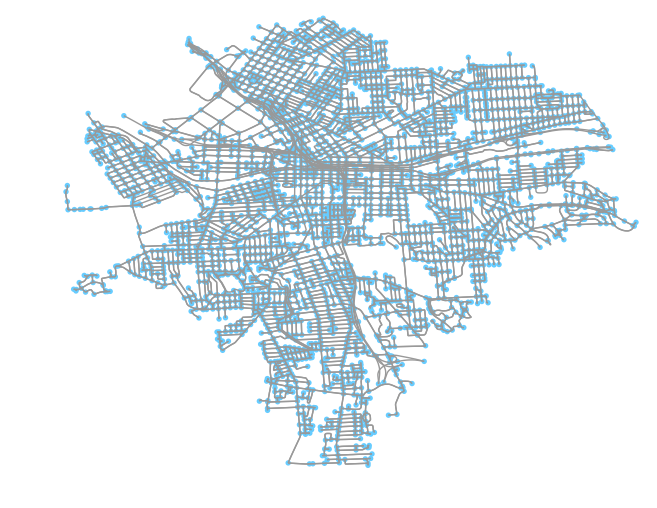

(<matplotlib.figure.Figure at 0x1cf992b1f28>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1cfa365a518>)

In [2]:
# Importing the City Network

G = ox.graph_from_place('Syracuse, USA', network_type='drive')
ox.plot_graph(G)

In [3]:
ox.save_graph_shapefile(G, filename='city_network')

In [4]:
# Loading the Edge Data

city_edge = gpd.read_file('Data/city_network/edges/edges.shp')
city_edge = city_edge[['osmid', 'name', 'geometry', 'length', 'highway', 'lanes']]
city_edge.head()

,osmid,name,geometry,length,highway,lanes
0,"[295587203, 20129781]",East Brighton Avenue,"LINESTRING (-76.14297910000001 43.0206958, -76...",162.3436586089952,tertiary,"['3', '2']"
1,295587211,South State Street,"LINESTRING (-76.1409858 43.0209248, -76.140964...",58.446277978588654,primary,3
2,295587201,East Brighton Avenue,"LINESTRING (-76.1410327 43.0204078, -76.140840...",17.09061864608954,tertiary,2
3,20118797,South State Street,"LINESTRING (-76.1410327 43.0204078, -76.141056...",26.95234967010755,primary,2
4,20150830,Arthur Street,"LINESTRING (-76.17716900000001 43.034878, -76....",102.03312701271345,residential,None


In [5]:
# Loading Syracuse Accelerometer Data, Cleaning it up and making it into a Geodataframe

syra_acc = pd.read_csv('SQUID_SYRACUSE_MASTER_APR29.csv')
syra_acc = syra_acc[['Lat', 'Lon', 'Speed', 'X', 'Y', 'Z']]
syra_acc['vibration'] = ((syra_acc['X'])**2 + (syra_acc['Y'])**2 + (syra_acc['Z'])**2)**(1/2)
syra_acc = syra_acc[['Lat','Lon','Speed','vibration']]

geometry = gpd.GeoSeries([Point(xy) for xy in zip(syra_acc.Lon, syra_acc.Lat)])

syra_acc = gpd.GeoDataFrame(syra_acc, geometry=geometry)
syra_acc.crs = {'init' :'epsg:4326'}
syra_acc = syra_acc[['geometry','Speed','vibration',]]

syra_acc_x = syra_acc

syra_acc.head()

,geometry,Speed,vibration
0,POINT (-76.109782 43.055093),5.26,0.775284
1,POINT (-76.109803 43.055062),6.13,0.953227
2,POINT (-76.10984300000001 43.05498499999999),12.04,0.654811
3,POINT (-76.10987 43.054932),13.67,0.681340
4,POINT (-76.109898 43.054878),15.51,0.922900


In [6]:
city_edge_buff = gpd.GeoDataFrame(city_edge)
city_edge_buff['geometry'] = city_edge_buff.buffer(0.00013)
city_edge_buff.crs = {'init' :'epsg:4326'}
city_edge_buff.head()

,osmid,name,geometry,length,highway,lanes
0,"[295587203, 20129781]",East Brighton Avenue,POLYGON ((-76.14249922110189 43.02078881649258...,162.3436586089952,tertiary,"['3', '2']"
1,295587211,South State Street,POLYGON ((-76.14083864323719 43.02087057143594...,58.446277978588654,primary,3
2,295587201,East Brighton Avenue,POLYGON ((-76.14080055615388 43.02047013975223...,17.09061864608954,tertiary,2
3,20118797,South State Street,POLYGON ((-76.14092615478373 43.02027558277786...,26.95234967010755,primary,2
4,20150830,Arthur Street,POLYGON ((-76.17736664326172 43.03578437582774...,102.03312701271345,residential,None


In [7]:
geo_syra_acc = gpd.sjoin(syra_acc, city_edge_buff, how = 'inner', op = 'within')
#geo_syra_acc = geo_syra_acc[['osmid','geometry', 'length','Speed','vibration']]
geo_syra_acc = geo_syra_acc[geo_syra_acc['highway'] == 'residential']
geo_syra_acc = geo_syra_acc[geo_syra_acc['lanes'].isin(['1', '2', '3', None])]
geo_syra_acc.reset_index(inplace=True)
geo_syra_acc = geo_syra_acc[['osmid', 'name', 'geometry', 'length', 'highway', 'lanes', 'Speed', 'vibration']]
geo_syra_acc.head()

,osmid,name,geometry,length,highway,lanes,Speed,vibration
0,20127617,Beattie Street,POINT (-76.108503 43.050898),252.30004574069568,residential,2,78.20,0.567579
1,20127617,Beattie Street,POINT (-76.108317 43.05069),252.30004574069568,residential,2,78.83,0.595571
2,20127617,Beattie Street,POINT (-76.10856 43.050723),252.30004574069568,residential,2,5.13,0.303975
3,20127617,Beattie Street,POINT (-76.10852299999999 43.050717),252.30004574069568,residential,2,5.66,0.374884
4,20127617,Beattie Street,POINT (-76.108503 43.05071),252.30004574069568,residential,2,5.93,0.526857


geo_syra_acc = geo_syra_acc[geo_syra_acc['Speed'] <= 70]

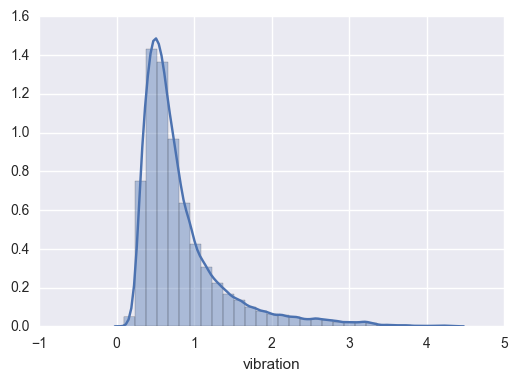

In [8]:
sns.distplot(geo_syra_acc['vibration'], kde=True, bins=30)

In [9]:
geo_syra_acc['vibration'].median()

0.6539067211766522

In [10]:
geo_syra_acc = geo_syra_acc.apply(pd.to_numeric, errors='ignore')

In [12]:
syra_acc_grp_1 = geo_syra_acc.groupby(by='osmid',axis=0).max()
syra_acc_grp_1.reset_index(inplace=True)
syra_acc_grp_2 = geo_syra_acc.groupby(by='osmid',axis=0).mean()
syra_acc_grp_2.reset_index(inplace=True)

In [13]:
syra_acc_grp = pd.merge(syra_acc_grp_1,syra_acc_grp_2,on='osmid')
syra_acc_grp = syra_acc_grp[['length_y','vibration_x', 'Speed_y']]
#syra_acc_grp = syra_acc_grp[['osmid', 'name', 'length', 'vibration_y', 'Speed_x']]
#syra_acc_grp.columns = ['Length','Max_Vibration','mean_speed']
syra_acc_grp = syra_acc_grp.apply(pd.to_numeric, errors='ignore')
syra_acc_grp.head()

,length_y,vibration_x,Speed_y
0,227.863283,1.730785,27.995000
1,168.407340,2.911115,16.513834
2,64.967075,0.775204,26.627778
3,106.853254,1.003004,19.262500
4,27.922998,1.203414,22.066000


In [15]:
syra_acc_grp_x = syra_acc_grp
syra_acc_grp_x.columns = ['Length','Max_vibration', 'Mean_Speed']

In [16]:
syra_acc_grp.dtypes

Length           float64
Max_vibration    float64
Mean_Speed       float64
dtype: object

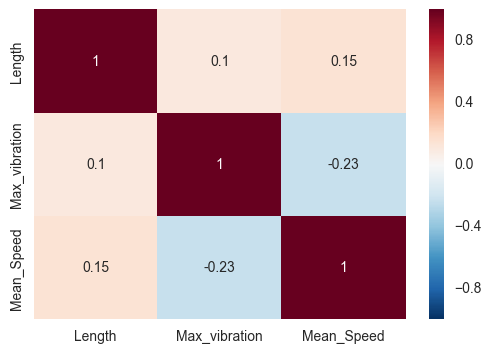

In [17]:
sns.heatmap(syra_acc_grp_x.corr(),annot=True)

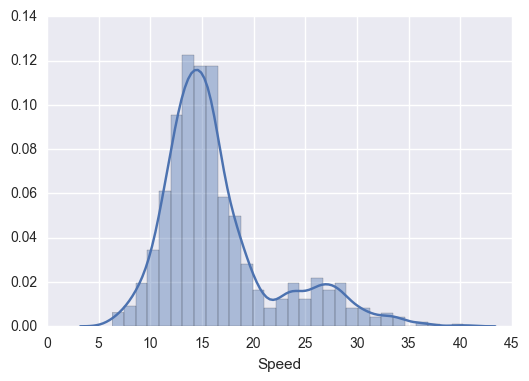

In [18]:
syra_acc_grp_x.columns = ['Length','vibration', 'Speed']
sns.distplot(syra_acc_grp_x['Speed'], kde=True, bins=30)

In [19]:
# SPlitting the Data into into Bins of 10mph

syra_acc_grp_1 = syra_acc_grp_x[syra_acc_grp_x['Speed'] < 10]
syra_acc_grp_x = syra_acc_grp_x[syra_acc_grp_x['Speed'] >= 10]

syra_acc_grp_2 = syra_acc_grp_x[syra_acc_grp_x['Speed'] < 20]
syra_acc_grp_x = syra_acc_grp_x[syra_acc_grp_x['Speed'] >= 20]

syra_acc_grp_3 = syra_acc_grp_x[syra_acc_grp_x['Speed'] < 30]
syra_acc_grp_x = syra_acc_grp_x[syra_acc_grp_x['Speed'] >= 30]

syra_acc_grp_4 = syra_acc_grp_x[syra_acc_grp_x['Speed'] < 40]
syra_acc_grp_x = syra_acc_grp_x[syra_acc_grp_x['Speed'] >= 40]

syra_acc_grp_5 = syra_acc_grp_x[syra_acc_grp_x['Speed'] >= 40]

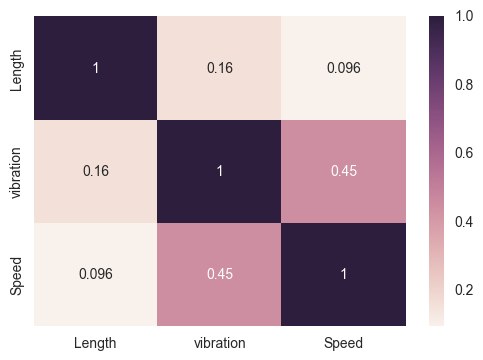

In [20]:
sns.heatmap(syra_acc_grp_1.corr(),annot=True)

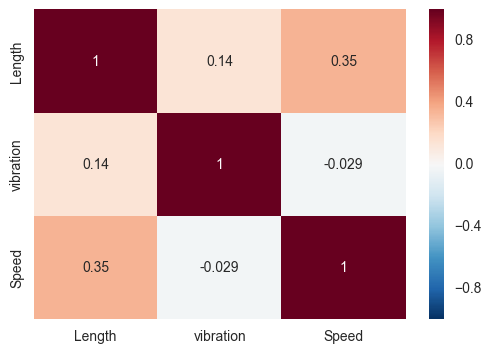

In [21]:
sns.heatmap(syra_acc_grp_2.corr(),annot=True)

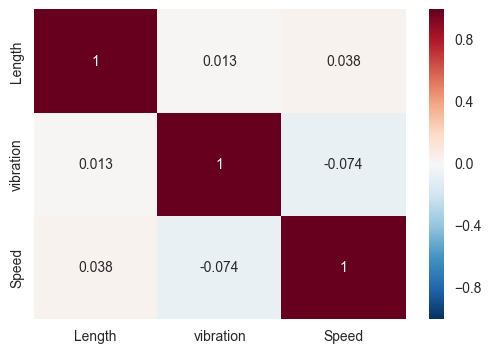

In [22]:
sns.heatmap(syra_acc_grp_3.corr(),annot=True)

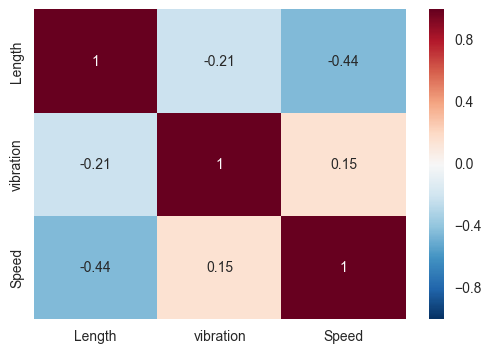

In [23]:
sns.heatmap(syra_acc_grp_4.corr(),annot=True)

In [27]:
# print(syra_acc_grp_1['0-10mph'].mean())
# print(syra_acc_grp_1['0-10mph'].median())

In [28]:
# print(syra_acc_grp_2['10-20mph'].mean())
# print(syra_acc_grp_2['10-20mph'].median())

In [29]:
# print(syra_acc_grp_3['20-30mph'].mean())
# print(syra_acc_grp_3['20-30mph'].median())

In [30]:
# print(syra_acc_grp_4['30-40mph'].mean())
# print(syra_acc_grp_4['30-40mph'].median())

C:\Program Files\Anaconda3\lib\site-packages\pandas\core\frame.py:2834: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


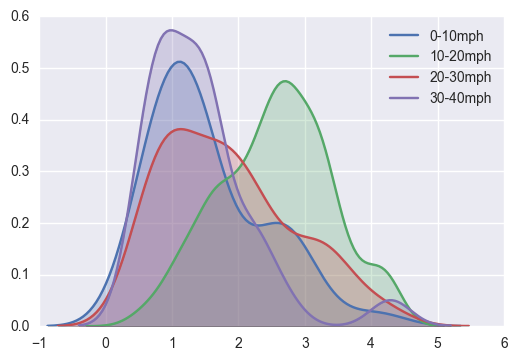

In [31]:
syra_acc_grp_1.rename(columns={'vibration': '0-10mph'},inplace=True)
syra_acc_grp_2.rename(columns={'vibration': '10-20mph'},inplace=True)
syra_acc_grp_3.rename(columns={'vibration': '20-30mph'},inplace=True)
syra_acc_grp_4.rename(columns={'vibration': '30-40mph'},inplace=True)
syra_acc_grp_5.rename(columns={'vibration': '> 40mph'},inplace=True)

sns.kdeplot(syra_acc_grp_1['0-10mph'], shade=True, legend=True)
sns.kdeplot(syra_acc_grp_2['10-20mph'], shade=True, legend=True)
sns.kdeplot(syra_acc_grp_3['20-30mph'], shade=True, legend=True)
sns.kdeplot(syra_acc_grp_4['30-40mph'], shade=True)
#sns.kdeplot(syra_acc_grp_5['> 40mph'], shade=True)

# Regression

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

X = pd.DataFrame(syra_acc_grp[['Length','vibration']])
y = pd.DataFrame(syra_acc_grp['Speed'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

lm = LinearRegression()

results = lm.fit(X_train,y_train)

lm.coef_

cdf = pd.DataFrame(lm.coef_.transpose(),X.columns,columns=['Coeff'])
cdf

,Coeff
Length,0.009346
vibration,-1.336756


# OLS Regression

In [37]:
import statsmodels.api as sm


In [39]:
mod = sm.OLS(syra_acc_grp.Speed, syra_acc_grp.vibration)

res = mod.fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  Speed   R-squared:                       0.732
Model:                            OLS   Adj. R-squared:                  0.731
Method:                 Least Squares   F-statistic:                     2316.
Date:                Thu, 11 May 2017   Prob (F-statistic):          8.14e-245
Time:                        05:22:39   Log-Likelihood:                -3075.9
No. Observations:                 850   AIC:                             6154.
Df Residuals:                     849   BIC:                             6159.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
vibration      5.8564      0.122     48.126      0.0

In [ ]:
fig, ax = plt.subplots()
fig = plt.plot(res,syra_acc_grp.Speed)